In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import models, layers

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,MaxPooling2D,Dropout,GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import precision_score,recall_score,average_precision_score,mean_absolute_error,label_ranking_average_precision_score,f1_score,r2_score,accuracy_score,average_precision_score,precision_recall_curve,PrecisionRecallDisplay

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=5,width_shift_range=0.2,brightness_range=[0.2,0.8],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4)
traindata = train_datagen.flow_from_directory(
    'E:\\Papers\\kartikey\\APPLE_DISEASE_DATASET',
    target_size=(290,578,),
    subset='training') # set as training data

testdata = train_datagen.flow_from_directory(
    'E:\\Papers\\kartikey\\APPLE_DISEASE_DATASET', # same directory as training data
    target_size=(290,578,),
    subset='validation') # set as validation data

x_train, y_train = next(traindata)
x_test, y_test = next(testdata)


input_shape=(290,578,3)
no_of_class=4
classes=os.listdir('E:\\Papers\\kartikey\\APPLE_DISEASE_DATASET')

Found 253 images belonging to 4 classes.
Found 166 images belonging to 4 classes.


(848, 419, 3)


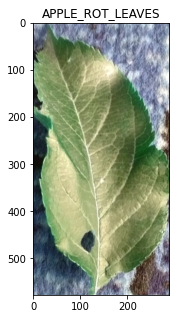

(1221, 678, 3)


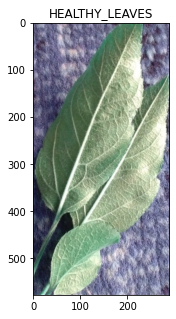

(509, 250, 3)


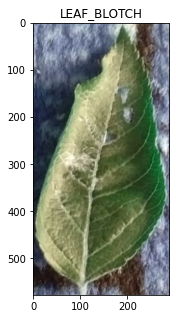

(938, 354, 3)


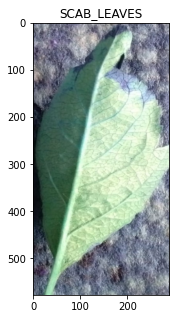

In [3]:
path="APPLE_DISEASE_DATASET"
arr=[]
names=[]
for i in os.listdir(path):
    for j in os.listdir(path+'/'+i):
        img=cv2.imread(path+"/"+i+'/'+j)
        print(img.shape)
        fig=plt.figure(figsize=(10,5))
        img=cv2.resize(img,(290,578))
        arr.append(img)
        plt.imshow(img)
        names.append(i)
        plt.title(i)
        plt.show()
        break

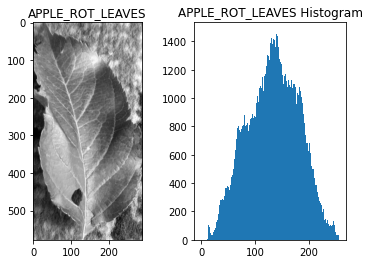

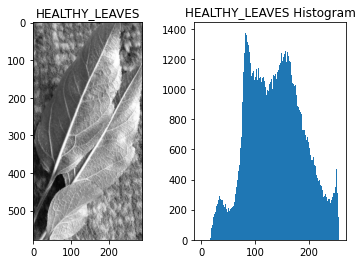

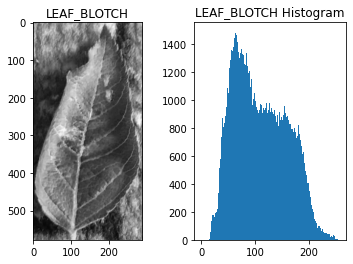

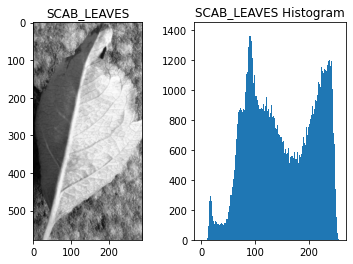

In [4]:
for i,j in zip(arr,names):
    fig,ax=plt.subplots(1,2)
    i=cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    ax[0].imshow(i,'gray')
    ax[1].hist(i.ravel(),256,[0,256])
    ax[0].set_title(j)
    ax[1].set_title(j+" Histogram")
    plt.show()

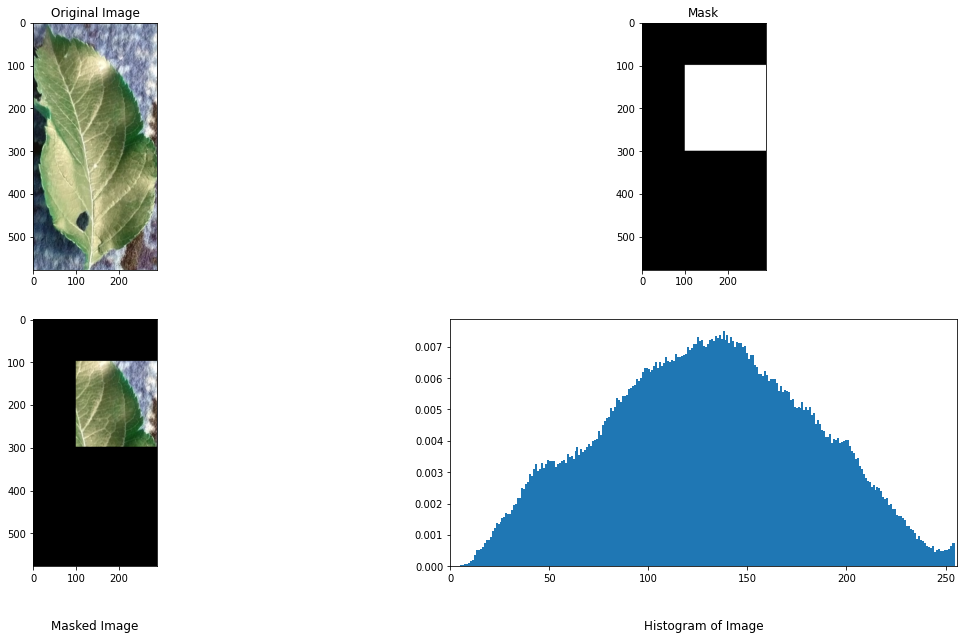

In [5]:
mask = np.zeros(arr[0].shape[:2], np.uint8)
mask[100:300, 100:400] = 255

masked_img = cv2.bitwise_and(arr[0],arr[0],mask = mask)
# Calculate histogram with mask and without mask
# Check third argument for mask
# hist_full = cv2.calcHist([k],[0],None,256,[1,256])
# hist_mask = cv2.calcHist([k],[0],mask,256,[1,256])

plt.figure(figsize=(20,10))
plt.subplot(221), plt.imshow(arr[0],'gray')
plt.title('Original Image')

plt.subplot(222), plt.imshow(mask,'gray')
plt.title('Mask')

plt.subplot(223), plt.imshow(masked_img,'gray')
plt.title('Masked Image',y=-0.2, pad=-14)

plt.subplot(224), plt.hist(arr[0].ravel(),256,[1,256],'gray')
plt.title('Histogram of Image',y=-0.2, pad=-14)
plt.xlim([0,256])
plt.show()

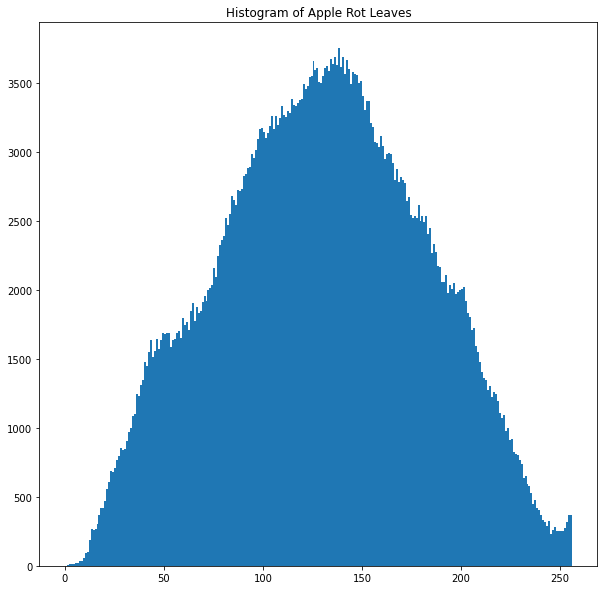

In [6]:
plt.figure(figsize=(10,10))
plt.hist(arr[0].ravel(),256,[0,256])
plt.title("Histogram of Apple Rot Leaves")
plt.show()

In [7]:
y_temp=[y_train[1]]
x_temp=np.asarray([x_train[1]])
# x_temp = x_temp.reshape((290, 578, ))
datagen = ImageDataGenerator(rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True  # horizontal flip
                                   )
i=0
t=[]
for x,y in datagen.flow(x_temp,y_temp,shuffle=False):
    t.append(x[0])
    print(i)
    i+=1
    if(i==4):
        break

0
1
2
3


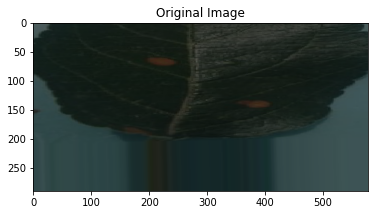

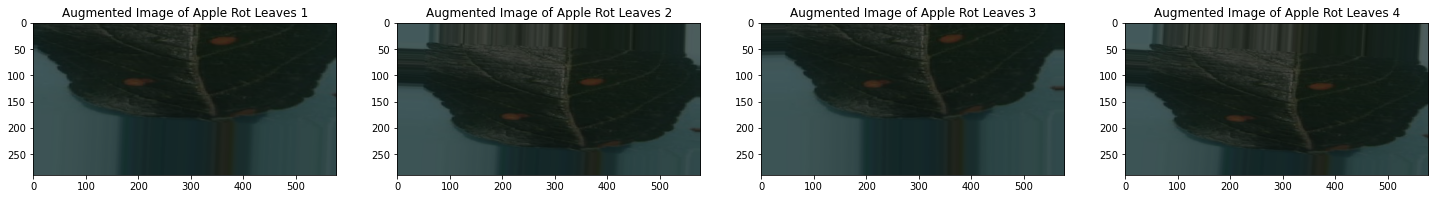

In [8]:
plt.imshow(x_temp[0])
plt.title('Original Image')
plt.show()

fig,ax=plt.subplots(1,4,figsize=(25,5))
for i in range(len(t)):
    ax[i].set_title('Augmented Image of Apple Rot Leaves '+str(i+1))
    ax[i].imshow(t[i])
plt.show()

In [9]:
def plot_model(hist,model_name):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title(model_name+" accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Accuracy", "Validation Accuracy", "loss", "Validation Loss"])
    plt.show()

def plot_confusionmatrix(model,y_test):
    y_pred=model.predict(x_test) 
    y_pred=np.argmax(y_pred, axis=1)
    test=np.argmax(y_test, axis=1)
    cm = confusion_matrix(test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
    disp.plot()

result=pd.DataFrame(columns=['Name of Model','accuracy',"F1-Score","R2-Score","Precision",'Recall','MAE'])
result

def addResult(model_name,model,y_test):
    pred=model.predict(x_test)
    pred=np.argmax(pred, axis=1)
    test=np.argmax(y_test, axis=1)
    result.loc[len(result.index)]=[model_name,
                                    accuracy_score(pred,test),
                                    f1_score(pred,test,average='weighted'),
                                    r2_score(pred,test),
                                    precision_score(pred,test,average='weighted'),
                                    recall_score(pred,test,average='weighted'),
                                    mean_absolute_error(test,pred)]

def plot_precisionrecallcurve(model,test):
    y_pred=model.predict(x_test) 
    # y_pred=np.argmax(y_pred, axis=1)
    # test=np.argmax(test, axis=1)
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(test[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(test[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        test.ravel(), y_pred.ravel()
    )
    average_precision["micro"] = average_precision_score(test, y_pred, average="micro")
    display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
                                        )
    display.plot()
    _ = display.ax_.set_title("Micro-averaged over all classes")
    plt.show()


In [25]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 20

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "APPLE_DISEASE_DATASET",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 419 files belonging to 4 classes.


In [12]:
class_names = dataset.class_names
class_names

['APPLE_ROT_LEAVES', 'HEALTHY_LEAVES', 'LEAF_BLOTCH', 'SCAB_LEAVES']

(32, 256, 256, 3)
[0 0 2 2 2 2 1 0 2 2 1 3 0 3 2 3 2 3 2 1 1 2 3 0 3 3 0 2 0 2 3 0]


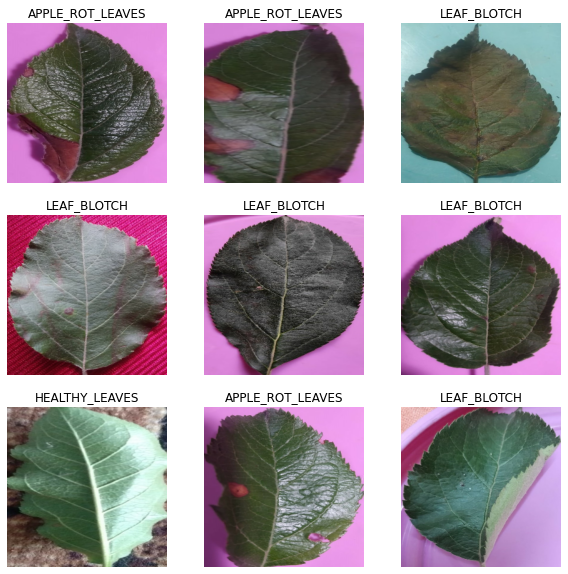

In [13]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(0,9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [14]:
len(dataset)


14

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.9, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    test_size = int(test_split * ds_size)
    
    train_ds = ds.take(train_size)    
    test_ds = ds.skip(test_size)
    
    return train_ds, test_ds

In [16]:
train_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2)
])

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape, padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256,  (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
hist = model.fit(
    train_ds,
    validation_data=test_ds,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/20
12/12 [==============================] - 20s 2s/step - loss: 1.0344 - accuracy: 0.4451 - val_loss: 1.0455 - val_accuracy: 0.4574
Epoch 2/20
12/12 [==============================] - 20s 2s/step - loss: 1.0655 - accuracy: 0.4310 - val_loss: 1.0680 - val_accuracy: 0.4367
Epoch 3/20
12/12 [==============================] - 20s 2s/step - loss: 1.0547 - accuracy: 0.4563 - val_loss: 1.0308 - val_accuracy: 0.4496
Epoch 4/20
12/12 [==============================] - 20s 2s/step - loss: 1.0364 - accuracy: 0.4451 - val_loss: 1.0229 - val_accuracy: 0.4212
Epoch 5/20
12/12 [==============================] - 19s 2s/step - loss: 1.0290 - accuracy: 0.4394 - val_loss: 1.0514 - val_accuracy: 0.4522
Epoch 6/20
12/12 [==============================] - 20s 2s/step - loss: 1.0249 - accuracy: 0.4563 - val_loss: 1.0216 - val_accuracy: 0.4780
Epoch 7/20
12/12 [==============================] - 21s 2s/step - loss: 1.0467 - accuracy: 0.4197 - val_loss: 1.0262 - val_accuracy: 0.4755
Epoch 8/20
12/12 [==

1/1 [==============================] - 0s 328ms/step


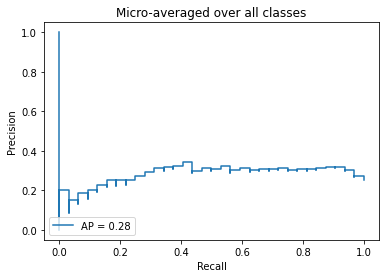

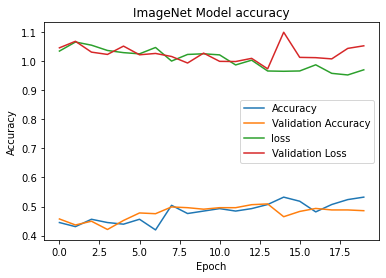

1/1 [==============================] - 0s 320ms/step


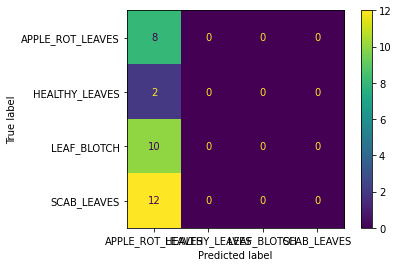

In [28]:
plot_precisionrecallcurve(model,y_test)
plot_model(hist,'ImageNet Model')
addResult("9",model,y_test)
plot_confusionmatrix(model,y_test)

In [29]:
result

,Name of Model,accuracy,F1-Score,R2-Score,Precision,Recall,MAE
0,9,0.375,0.545455,0.0,1.0,0.375,1.1875
1,9,0.250,0.400000,0.0,1.0,0.250,1.8125
